In [1]:
import pandas as pd
import geopandas as gp
from shapely.geometry import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import flopy as fp
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import rasterio

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
def resample_rast(rast_path,grid,band=1):
    arr = Raster.load(rast_path)
    arr = arr.resample_to_grid(grid.xcellcenters,grid.ycellcenters,band)
    return arr

In [3]:
# extract boundaries data from surfaces
MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
x0,y0,x1,y1 = rasterio.open(MNT_path).bounds
x1 -= 3e4
# set resolution of the array
res = 50
Lx = x1-x0
Ly = y1-y0
nrow = int(Ly/res)
ncol = int(Lx/res)

#create grid with flopy
grid = fp.discretization.StructuredGrid(delc=res*np.ones([nrow]),delr=res*np.ones([ncol]),xoff=x0,yoff=y0)
ix = GridIntersect(grid)

In [4]:
shp = "zones_irrigation/zCan.shp" # a shp polygon near Canet where irrigation is only provided by wells
parcelles = "parcelles/Parcelles.shp" # a shp with mulitple polygons, one per culture on the plain
zones_irr = "zones_irrigation/Zirr_mod.shp" #list of irrigation zones made by Brli

In [5]:
#load shp
parc = gp.read_file(parcelles)
zCan = gp.read_file(shp)
zIrr = gp.read_file(zones_irr)

#append the polygon from Canet

zCan["Surf_Z_Ha"] = zCan.geometry[0].area/1e4 #get area
zCan["Irr_forage"] = 1 # add info about irrgation source

zIrr = zIrr.append(zCan,sort=False).reset_index(drop=True)

# ajout d'une colonne pour l'irrigation par canaux
zIrr["Irr_can"] = 1-zIrr["Irr_forage"]
zIrr.loc[zIrr["Zones"]=="Zone 4","Irr_can"]=0

In [6]:
#calculate area per culture type and by zones
surf=[]

## calculate surface for each culture
for zi in range(zIrr.shape[0]):
    mask=[]
    for p in range(parc.shape[0]):
        mask.append(zIrr.geometry[zi].intersects(parc.geometry[p]))
    df = parc.loc[mask].groupby(["Name"]).sum()["Surf_P_Ha"]
    
    surf_mar=0
    surf_verg=0
    for i in range(df.shape[0]):
        if df.index[i] == "Verger":
            surf_verg = df.values[i]
        if df.index[i] == 'Maraichage':
            surf_mar = df.values[i]
                    
    surf.append((zIrr.loc[zi,"Zones"],surf_mar,surf_verg))

In [7]:
surf = pd.DataFrame(surf,columns=["Zones","area_maraichage [Ha]","area_verger [Ha]"])

- maraichage 90 % d'hiver 10 % d'été
- verger 30 % abricots et 70 % pêchers

In [8]:
mara_e = np.array([353,417,494])
mara_h = np.array([25,46,60])
abr = np.array([144,190,252])
pech = np.array([458,545,648])

In [9]:
verger = 0.3*abr+0.7*pech
mara = 0.9*mara_h+0.1*mara_e

# facteur besoins
z=3
besoins = np.ones([zIrr.shape[0],2])
for i,z in enumerate(zIrr["ZC"]):
    besoins[int(i)] = [mara[z-1],verger[z-1]]

W_need = surf.set_index("Zones")*10*besoins
W_need.columns = ["w_need_mar [m$^3$]","w_need_verg [m$^3$]"]

In [10]:
cm = sns.light_palette("blue", as_cmap=True)
W_need.reset_index().style.background_gradient(cmap=cm)

,Zones,w_need_mar [m$^3$],w_need_verg [m$^3$]
0,Zone 7,6465.18,1.17189e+06
1,Zone 8,88107.1,1.07809e+06
2,Zone 7,1969.47,236088
3,Zone 4,441208,2.09373e+06
4,Zone 2B,20855.8,2.53243e+06
5,Zone 3B,24867.7,28312.2
6,Zone 3,112634,212103
7,Zone 3,96172.3,328104
8,Zone 3,96637,7.34803e+06
9,Zone 6,754.82,506180


In [11]:
print("Total Water need: {} m3".format(W_need.sum().iloc[0:2].sum()))
print("Calculs de Brli : 30 millions de m3")

Total Water need: 26063115.27 m3
Calculs de Brli : 30 millions de m3


Il manque l'intégration de quelques cultures en dehors des shp, ainsi que des prairies

In [12]:
# sum water need
df = W_need.sum(axis=1).reset_index()
df.columns = ["Zones","Water_need/year"]

In [13]:
# merge data and get water need in mm/y
data_irrig = pd.merge(zIrr.reset_index(),df.reset_index()).drop("index",axis=1).loc[:,["Zones","Irr_forage","geometry","Surf_Z_Ha","Water_need/year","Irr_can"]]
data_irrig["Wneed [mm/year]"] = data_irrig.loc[:,"Water_need/year"]/data_irrig.loc[:,"Surf_Z_Ha"]*1e-1
#data_irrig = data_irrig.drop(["Water_need/year","Surf_Z_Ha"],axis=1)

In [14]:
data_irrig

,Zones,Irr_forage,geometry,Surf_Z_Ha,Water_need/year,Irr_can,Wneed [mm/year]
0,Zone 7,0.00,"POLYGON ((689548.932 6159779.286, 689330.629 6...",1235.030000,1178356.43,1.00,95.411158
1,Zone 8,0.80,"POLYGON ((702638.710 6164713.007, 702702.478 6...",1694.310000,1166193.38,0.20,68.829989
2,Zone 7,0.00,"MULTIPOLYGON (((683722.928 6156383.584, 683813...",1227.440000,238057.87,1.00,19.394665
3,Zone 4,0.70,"POLYGON ((700069.343 6173529.460, 701428.421 6...",7033.390000,2534934.68,0.00,36.041435
4,Zone 2B,0.30,"POLYGON ((678247.347 6173329.417, 678248.682 6...",799.450000,2553289.46,0.70,319.380757
5,Zone 3B,0.75,"POLYGON ((691908.474 6179742.319, 691911.937 6...",410.770000,53179.90,0.25,12.946393
6,Zone 3,0.75,"POLYGON ((692589.108 6178710.935, 693491.651 6...",402.030000,324736.98,0.25,80.774315
7,Zone 3,0.75,"POLYGON ((681182.001 6177675.798, 681201.069 6...",1766.310000,424276.34,0.25,24.020491
8,Zone 3,0.75,"POLYGON ((673869.847 6177678.511, 673893.666 6...",5964.980000,7444669.19,0.25,124.806272
9,Zone 6,0.80,"POLYGON ((694653.450 6185424.447, 694630.271 6...",233.280000,506934.62,0.20,217.307365


#### Calcul des prélèvements agricoles sur la base des besoins en eaux X le mode d'adduction de chaque zone

In [15]:
arr = np.zeros([nrow,ncol])
for iz in range(data_irrig.shape[0]):
    res = ix.intersect_polygon(data_irrig.geometry[iz])
    for cellid in res.cellids:
        arr[cellid[0],cellid[1]] = -data_irrig.loc[iz,"Wneed [mm/year]"]*data_irrig.loc[iz,"Irr_forage"]

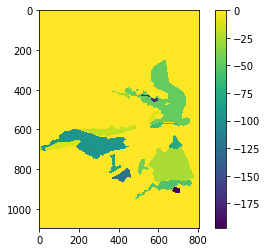

In [16]:
arr = np.round(arr,decimals=1)
plt.imshow(arr)
plt.colorbar()

In [17]:
def arr2ascii(arr,filename,x0,y0,res,nodata=-9999):
    ncol = arr.shape[1]
    nrow = arr.shape[0]
    with open(filename,"w") as file:
        file.write("ncols {}\n".format(ncol))
        file.write("nrows {}\n".format(nrow))
        file.write("xllcorner {}\n".format(x0))
        file.write("yllcorner {}\n".format(y0))
        file.write("cellsize {}\n".format(res))
        file.write("nodata_value {}\n".format(nodata))
        for irow in range(nrow):
            for icol in range(ncol):
                file.write(str(arr[irow,icol])+" ")

In [18]:
arr2ascii(arr,"../../data/prélèvements/prlvm_agri.asc",x0,y0,50)

In [19]:
(arr/1000*50*50).sum()

-17496021.5

#### Calcul des retours nappes des canaux

In [20]:
coeff = 2 # !!! Coefficient de 2 déjà appliqué donc coeff à définir entre 1 et 2 dans le modèle.

rch_a = np.zeros([nrow,ncol])
for iz in range(data_irrig.shape[0]):
    res = ix.intersect_polygon(data_irrig.geometry[iz])
    for cellid in res.cellids:
        rch_a[cellid[0],cellid[1]] = data_irrig.loc[iz,"Wneed [mm/year]"]*data_irrig.loc[iz,"Irr_can"]*coeff

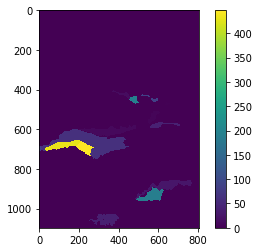

In [21]:
rch_a = np.round(rch_a,decimals=1)
plt.imshow(rch_a)
plt.colorbar()

In [24]:
arr2ascii(rch_a,"../../data/recharge/rast_irr.asc",x0,y0,50)

In [23]:
(rch_a/1000*50*50).sum()

17003931.25